In [7]:
import scipy, time
from scipy.integrate import quad
from scipy.interpolate import interp1d
from scipy.io import FortranFile
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline
from numpy import exp, log, log10, cos, sin, pi, cosh, sinh , sqrt, amin, amax, mean, dot, power, conj
import matplotlib
from matplotlib import pyplot as plt
import sys
%matplotlib inline

dire='/Users/digvijay/Dropbox/Drop_Acad/Roman/Covariance/data/Public/'

In [28]:
# for aesthetic plots
font = {'size'   : 14, 'family':'STIXGeneral'}
matplotlib.rc('font', **font)
matplotlib.rc('axes', labelsize=18) 
matplotlib.mathtext.rcParams['legend.fontsize']=14
plt.rcParams["figure.figsize"] = [6.0,4.]
matplotlib.rc('text', usetex=True)

In [14]:
#Using the window kernels calculated from the survey random catalog as input
#See Survey_window_kernels.ipynb for the code to generate these window kernels using the Wij() function

WijFile=np.load(dire+'Wij_k120_HighZ_NGC.npy')

#Please download the files from the link:
# https://drive.google.com/drive/folders/1bWKfUaIXcC1n-2hk9KtKhqukxTH1379i?usp=sharing

In [15]:
# Include here the theory power spectrum best-fitted to the survey data
# Currently I'm using here the Patchy output to show the comparison with mock catalogs later

k=np.loadtxt(dire+'k_Patchy.dat'); kbins=len(k) #number of k-bins

pfit=[0,1,2,3,4]
pfit[0]=np.loadtxt(dire+'P0_fit_Patchy.dat')
pfit[2]=np.loadtxt(dire+'P2_fit_Patchy.dat')
pfit[4]=np.loadtxt(dire+'P4_fit_Patchy.dat')

#Hexadecapole has little contribution so, if not fitted, once can use linear theory + Kaiser as a good approximation

In [16]:
# For generating individual elements of the covariance matrix
# see Survey_window_kernels.ipynb for further details where the same function is used

def Cij(kt,Wij):
    temp=np.zeros((7,6));
    for i in range(-3,4):
        if(kt+i<0 or kt+i>=kbins):
            temp[i+3]=0.
            continue
        temp[i+3]=Wij[i+3,0]*pfit[0][kt]*pfit[0][kt+i]+\
        Wij[i+3,1]*pfit[0][kt]*pfit[2][kt+i]+\
        Wij[i+3,2]*pfit[0][kt]*pfit[4][kt+i]+\
        Wij[i+3,3]*pfit[2][kt]*pfit[0][kt+i]+\
        Wij[i+3,4]*pfit[2][kt]*pfit[2][kt+i]+\
        Wij[i+3,5]*pfit[2][kt]*pfit[4][kt+i]+\
        Wij[i+3,6]*pfit[4][kt]*pfit[0][kt+i]+\
        Wij[i+3,7]*pfit[4][kt]*pfit[2][kt+i]+\
        Wij[i+3,8]*pfit[4][kt]*pfit[4][kt+i]+\
        1.01*(Wij[i+3,9]*(pfit[0][kt]+pfit[0][kt+i])/2.+\
        Wij[i+3,10]*pfit[2][kt]+Wij[i+3,11]*pfit[4][kt]+\
        Wij[i+3,12]*pfit[2][kt+i]+Wij[i+3,13]*pfit[4][kt+i])+\
        1.01**2*Wij[i+3,14]
    return(temp)

In [17]:
def CovMat():
    covMat=np.zeros((2*kbins,2*kbins))
    for i in range(kbins):
        temp=Cij(i,WijFile[i])
        C00=temp[:,0]; C22=temp[:,1]; C20=temp[:,3];
        for j in range(-3,4):
            if(i+j>=0 and i+j<kbins):
                covMat[i,i+j]=C00[j+3]
                covMat[kbins+i,kbins+i+j]=C22[j+3]
                covMat[kbins+i,i+j]=C20[j+3]
    covMat[:kbins,kbins:kbins*2]=np.transpose(covMat[kbins:kbins*2,:kbins])
    covMat=(covMat+np.transpose(covMat))/2.
    return(covMat)

In [20]:
# Loading the non-Gaussian (NG) part from a data-file
# This file also has hexadecapole (Format: [L0 L2 L4] X [L0 L2 L4]) but I'm only using upto quadrupole
# I will soon upload a jupyter notebook showing how the file was calculated
covaNG=np.load(dire+'CovaNG_HighZ_NGC_k0.25_3x3.npy')[:100,:100]

In [21]:
temp=CovMat()+covaNG

In [23]:
# Loading the Patchy covariance matrix for comparison
# This file also has hexadecapole (Format: [L0 L2 L4] X [L0 L2 L4]) but I'm only using upto quadrupole
CovaPatchy=np.loadtxt(dire+'Patchy_CovarianceMatrix.dat')[:100,:100]

In [24]:
# For making plots comparing the diagonal elements

[plot,plot2,plot3,plot4,plot5,plot6]=np.zeros((6,kbins))
for i in range(kbins):
    plot[i]=CovaPatchy[i,i]/(pfit[0][i]*pfit[0][i])
    plot2[i]=temp[i,i]/(pfit[0][i]*pfit[0][i])
    plot3[i]=CovaPatchy[kbins+i,kbins+i]/(pfit[0][i]*pfit[0][i])
    plot4[i]=temp[kbins+i,kbins+i]/(pfit[0][i]*pfit[0][i])
    plot5[i]=CovaPatchy[kbins+i,i]/(pfit[0][i]*pfit[0][i])
    plot6[i]=temp[kbins+i,i]/(pfit[0][i]*pfit[0][i])

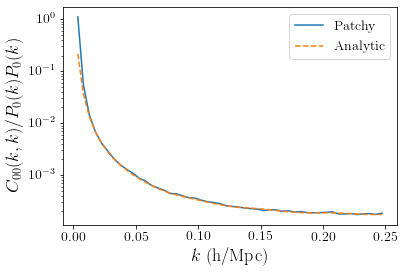

In [29]:
plt.semilogy(k,plot);
plt.semilogy(k,plot2, ls='dashed');
plt.xlabel(r'$k$ (h/Mpc)'); plt.ylabel(r'$C_{00}(k,k)/P_0 (k) P_0(k)$')
plt.legend(["Patchy","Analytic"], loc=1)

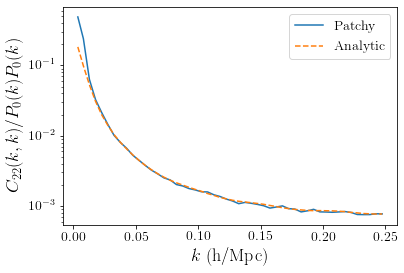

In [30]:
plt.semilogy(k,plot3);
plt.semilogy(k,plot4, ls='dashed');
plt.xlabel(r'$k$ (h/Mpc)'); plt.ylabel(r'$C_{22}(k,k)/P_0 (k) P_0(k)$')
plt.legend(["Patchy","Analytic"], loc=1)

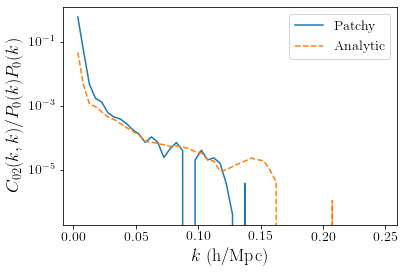

In [31]:
plt.semilogy(k,plot5);
plt.semilogy(k,plot6, ls='dashed');
plt.xlabel(r'$k$ (h/Mpc)'); plt.ylabel(r'$C_{02}(k,k)/P_0 (k) P_0(k)$')
plt.legend(["Patchy","Analytic"], loc=1)

# Extras

In [ ]:
#Linear power spectrum from Class or CAMB
pdata=np.loadtxt(dire+'Pk_lin_CAMB.dat')
Plin=InterpolatedUnivariateSpline(pdata[:,0], pdata[:,1])